<a href="https://colab.research.google.com/github/kempaaron/dissertation/blob/main/Kemp_Dissertation_2_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load data
file_path = '/content/drive/MyDrive/Colab Notebooks/ms_data_nox.csv'
data = pd.read_csv(file_path)

# Prepare data
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the transformer model
def transformer_model(hp):
    input_layer = layers.Input(shape=(X_train.shape[1], 1))

    x = input_layer
    for i in range(hp.Int('num_transformer_blocks', 1, 3)):
        attention_output = layers.MultiHeadAttention(num_heads=hp.Int('num_heads', 2, 8),
                                                     key_dim=hp.Int('key_dim', 32, 128))(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)
        x = layers.Dropout(rate=hp.Float('dropout', 0.1, 0.5))(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(rate=hp.Float('dropout_fc', 0.1, 0.5))(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(transformer_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=3,
                        directory='my_dir',
                        project_name='transformer_tuning')

tuner.search(X_train, y_train, epochs=10, validation_split=0.3)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Retrain the model with multiple runs and calculate average accuracy
runs = 1
accuracies = []
for _ in range(runs):
    best_model.fit(X_train, y_train, epochs=10, validation_split=0.3, verbose=0)
    _, acc = best_model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)
print(f'Average accuracy across {runs} runs: {average_accuracy}')

# Plot the loss from training and testing data across epochs
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.3, verbose=0)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Trial 5 Complete [00h 25m 36s]
val_accuracy: 0.5833333134651184

Best val_accuracy So Far: 0.5833333134651184
Total elapsed time: 01h 26m 40s
1/1 [==============================] - 6s 6s/step - loss: 0.6925 - accuracy: 0.5882
Test accuracy: 0.5882353186607361
Average accuracy across 1 runs: 0.5882353186607361


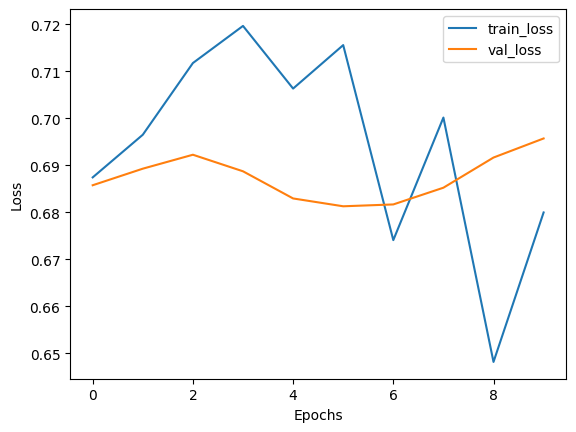

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load data
file_path = '/content/drive/MyDrive/Colab Notebooks/ms_data_nox.csv'
data = pd.read_csv(file_path)

# Prepare data
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# Reshape X to fit the expected input shape for the transformer model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the transformer model with Bi-LSTM
def transformer_model(hp):
    input_layer = layers.Input(shape=(X_train.shape[1], 1))

    # Add Bi-LSTM layers
    x = layers.Bidirectional(layers.LSTM(units=hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))(input_layer)

    for i in range(hp.Int('num_transformer_blocks', 1, 3)):
        attention_output = layers.MultiHeadAttention(num_heads=hp.Int('num_heads', 2, 8),
                                                     key_dim=hp.Int('key_dim', 32, 128))(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)
        x = layers.Dropout(rate=hp.Float('dropout', 0.1, 0.5))(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(rate=hp.Float('dropout_fc', 0.1, 0.5))(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(transformer_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=3,
                        directory='my_dir',
                        project_name='transformer_tuning')

tuner.search(X_train, y_train, epochs=10, validation_split=0.3)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Retrain the model with multiple runs and calculate average accuracy
runs = 1
accuracies = []
for _ in range(runs):
    best_model.fit(X_train, y_train, epochs=10, validation_split=0.3, verbose=0)
    _, acc = best_model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)
print(f'Average accuracy across {runs} runs: {average_accuracy}')

# Plot the loss from training and testing data across epochs
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.3, verbose=0)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Trial 5 Complete [00h 17m 14s]
val_accuracy: 0.5833333134651184

Best val_accuracy So Far: 0.5833333134651184
Total elapsed time: 02h 01m 14s
1/1 [==============================] - 4s 4s/step - loss: 0.6993 - accuracy: 0.5882
Test accuracy: 0.5882353186607361
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 0.7407 - accuracy: 0.5185 - val_loss: 0.6887 - val_accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 12s 12s/step - loss: 0.7323 - accuracy: 0.4815 - val_loss: 0.6811 - val_accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 14s 14s/step - loss: 0.6874 - accuracy: 0.5926 - val_loss: 0.6798 - val_accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 14s 14s/step - loss: 0.6416 - accuracy: 0.6667 - val_loss: 0.6827 - val_accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 13s 13s/step - loss: 0.7142 - accuracy: 0.4815 - val_loss: 0.6875 - val_accuracy: 0.5833
Epoch 6/20
1/1 [=============================

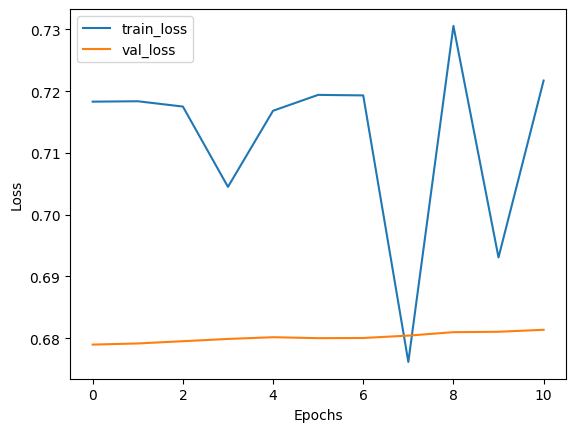

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load data
file_path = '/content/drive/MyDrive/Colab Notebooks/ms_data_nox.csv'
data = pd.read_csv(file_path)

# Prepare data
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# Reshape X to fit the expected input shape for the transformer model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the transformer model with Bi-LSTM
def transformer_model(hp):
    input_layer = layers.Input(shape=(X_train.shape[1], 1))

    # Add Bi-LSTM layers
    x = layers.Bidirectional(layers.LSTM(units=hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))(input_layer)

    for i in range(hp.Int('num_transformer_blocks', 1, 3)):
        attention_output = layers.MultiHeadAttention(num_heads=hp.Int('num_heads', 2, 8),
                                                     key_dim=hp.Int('key_dim', 32, 128))(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)
        x = layers.Dropout(rate=hp.Float('dropout', 0.1, 0.5))(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(rate=hp.Float('dropout_fc', 0.1, 0.5))(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(transformer_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=3,
                        directory='my_dir2',
                        project_name='transformer_tuning2')

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Retrain the model with multiple runs and calculate average accuracy
runs = 10
accuracies = []
for _ in range(runs):
    history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, verbose=1, callbacks=[early_stopping])
    _, acc = best_model.evaluate(X_test, y_test, verbose=1)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)
print(f'Average accuracy across {runs} runs: {average_accuracy}')

# Plot the loss from training and testing data across epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

NameError: name 'best_model' is not defined